In [11]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
from framed.io.sbml import sanitize_id
import reframed
from reframed.cobra.ensemble import load_ensemble
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

#### Neuroactive metabolites list

In [2]:
NeuroMetabDF=pd.read_excel('NeuroMetab.xlsx')
NeuroMetabList=NeuroMetabDF['BiGGIDnoM'].tolist()
NeuroMetabList=sorted(NeuroMetabList, reverse=True)

##### GPR rule for every <span style='color:Red'> neuroactive metabolite </span> of <span style='color:Blue'> one </span> model

In [3]:
ModelMetabs=[]
df = pd.DataFrame(columns=['reaction']) 
Dataframes=[]

model = read_sbml_model('LBmedium_Btheta_gram_gapFilled_after.xml.gz')
model.optimize()
for x in model.metabolites:
    ModelMetabs.append(x.id)
for NeuroMetab in NeuroMetabList:
    NeuroMetab=NeuroMetab.replace(" ' ", '')
    if NeuroMetab in ModelMetabs:
#         print(NeuroMetab)
        MetabSpecificData=[]
        producingDF=model.metabolites.get_by_id(NeuroMetab).summary().producing_flux
        prodList=producingDF['reaction'].unique().tolist()
#         print(len(prodList))
        consumingDF=model.metabolites.get_by_id(NeuroMetab).summary().consuming_flux
        consList=consumingDF['reaction'].unique().tolist()
#         print(len(consList))
        allRxs=sorted(list(set(prodList+consList)))
#         print(len(allRxs))
#         print(allRxs)
        for rx in allRxs:
            OneRow=[rx, True]
            MetabSpecificData.append(OneRow)
        MetabSpecificDF=pd.DataFrame(MetabSpecificData, columns=['reaction', NeuroMetab])  
#         print(MetabSpecificDF)
        Dataframes.append(MetabSpecificDF)
        
for each_DF in Dataframes:
    df=pd.merge(each_DF, df, on='reaction', how='outer').fillna(False)
# df       

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [47]:
NeuroRxDF=df.copy()
# NeuroRxDF=NeuroRxDF.sort_index(axis=1)
NeuroRxDF=NeuroRxDF*1 #from bool values to binary values
NeuroRxDF=NeuroRxDF.set_index('reaction')
NeuroRxDF

,3mb_e,3mb_p,ac_c,ac_e,ac_p,amet_c,but_c,but_e,but_p,glu__L_c,...,no_e,ppa_c,ppa_e,ppa_p,quln_c,taur_c,taur_e,taur_p,trp__L_c,trp__L_e
reaction,,,,,,,,,,,,,,,,,,,,,
3MBtex,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EX_3mb_e,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FACOAL50It2pp,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACKr,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACODA,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRPAS2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TRPS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TRPS2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [5]:
TransportersDF=pd.read_excel('transporters.xlsx')
ExchangesDF=pd.read_excel('exchanges.xlsx')

TransportersIDs=TransportersDF.ReactionID.unique()
ExchangesIDs=ExchangesDF.ReactionID.unique()

RxTypes=[]
for index, rows in NeuroRxDF.iterrows():
    if index in TransportersIDs:
        RxTypes.append("Transp")
    elif index in ExchangesIDs:
        RxTypes.append("Ex")
    else:
        RxTypes.append(" ")
        
NeuroRxDF["ReactionType"]=RxTypes
NeuroRxDF.index = NeuroRxDF.index.map(str) + " " + NeuroRxDF["ReactionType"].map(str)
NeuroRxDF=NeuroRxDF.drop(columns=['ReactionType'])
NeuroRxDF=NeuroRxDF.T
# NeuroRxDF

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (30,8))
# plt.figure(figsize = (8,40))

s=sns.heatmap(NeuroRxDF, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = reaction not present \n 1 = reaction present', 'location': 'top'}, linewidth=0.5, linecolor='gray')
s.set(xlabel='Reactions', ylabel='Neuroactive Metabolites')

for l in s.xaxis.get_ticklabels()+s.yaxis.get_ticklabels():
    if 'Transp' in l.get_text():
        l.set_color('m')
    elif 'Ex' in l.get_text():
        l.set_color('b')

# plt.savefig('neuroactiveRxsHeatmap.png',bbox_inches="tight")
# plt.savefig('neuroactiveRxsHeatmap.pdf', format="pdf",bbox_inches="tight")

# reactions and genes associated with gpr rules
# heatmap to see if a gene is associated with lots of reactions or not

In [50]:
allNeuroRxs=df.copy()
allNeuroRxs=allNeuroRxs['reaction'].unique().tolist()

rxDF = pd.DataFrame(columns=['gene']) 
genesDataframes=[]

for NeuroRx in allNeuroRxs:
    geneSpecificData=[]
    getReaction = model.reactions.get_by_id(NeuroRx)
    SpecificGPRrule = getReaction.gene_reaction_rule
    
    SpecificGPRruleList = []
    tmp = ''
    for c in SpecificGPRrule: #for each letter in the string "SpecificGPRrule"
        if c == ' ': #if letter is a space
            SpecificGPRruleList.append(tmp) #add quotation marks to the end of the list
            tmp = ''
        else: #if it is any other character
            tmp += c #add letter to empty string to form a string with one protein
    if tmp: #if tmp is empty
        SpecificGPRruleList.append(tmp) #then we will have one protein, a comma, a space (tmp) and another protein in quotation marks
        
    SpecificGPRruleList=list(filter(lambda a: a != "and", SpecificGPRruleList))
    SpecificGPRruleList=list(filter(lambda a: a != "or", SpecificGPRruleList))
    SpecificGPRruleList=list(filter(lambda a: a != "spontaneous", SpecificGPRruleList))
    SpecificGPRruleList = [re.sub(r'[()]', '', num) for num in SpecificGPRruleList]
    SpecificGPRruleList=list(set(SpecificGPRruleList))
    
    for gene in SpecificGPRruleList:
        OneRow=[gene, True]
        geneSpecificData.append(OneRow)
    genesDF=pd.DataFrame(geneSpecificData, columns=['gene', NeuroRx])  
    genesDataframes.append(genesDF)
        
for DF in genesDataframes:
    rxDF=pd.merge(DF, rxDF, on='gene', how='outer').fillna(False)
# rxDF  

,EX_trp__L_e,gene,TRPabc,TRPS2,TRPS1,TRPAS2,TAURtex,EX_taur_e,TAURabcpp,FDMO4_1,...,AGDC,ACt5pp,ACSERL,ACS,ACODA_1,ACODA,ACKr,FACOAL50It2pp,EX_3mb_e,3MBtex
0,False,WP_008764109_1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,WP_008760379_1,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,WP_011107308_1,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,WP_008765046_1,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,WP_011107821_1,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,False,WP_008761151_1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
104,False,WP_008765558_1,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
105,False,WP_011108898_1,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
106,False,WP_011108532_1,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [53]:
RxNgenesDF=rxDF.copy()
# NeuroRxDF=NeuroRxDF.sort_index(axis=1)
RxNgenesDF=RxNgenesDF*1 #from bool values to binary values
RxNgenesDF=RxNgenesDF.set_index('gene')
# RxNgenesDF

,EX_trp__L_e,TRPabc,TRPS2,TRPS1,TRPAS2,TAURtex,EX_taur_e,TAURabcpp,FDMO4_1,QULNS,...,AGDC,ACt5pp,ACSERL,ACS,ACODA_1,ACODA,ACKr,FACOAL50It2pp,EX_3mb_e,3MBtex
gene,,,,,,,,,,,,,,,,,,,,,
WP_008764109_1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WP_008760379_1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WP_011107308_1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WP_008765046_1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WP_011107821_1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WP_008761151_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WP_008765558_1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
WP_011108898_1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


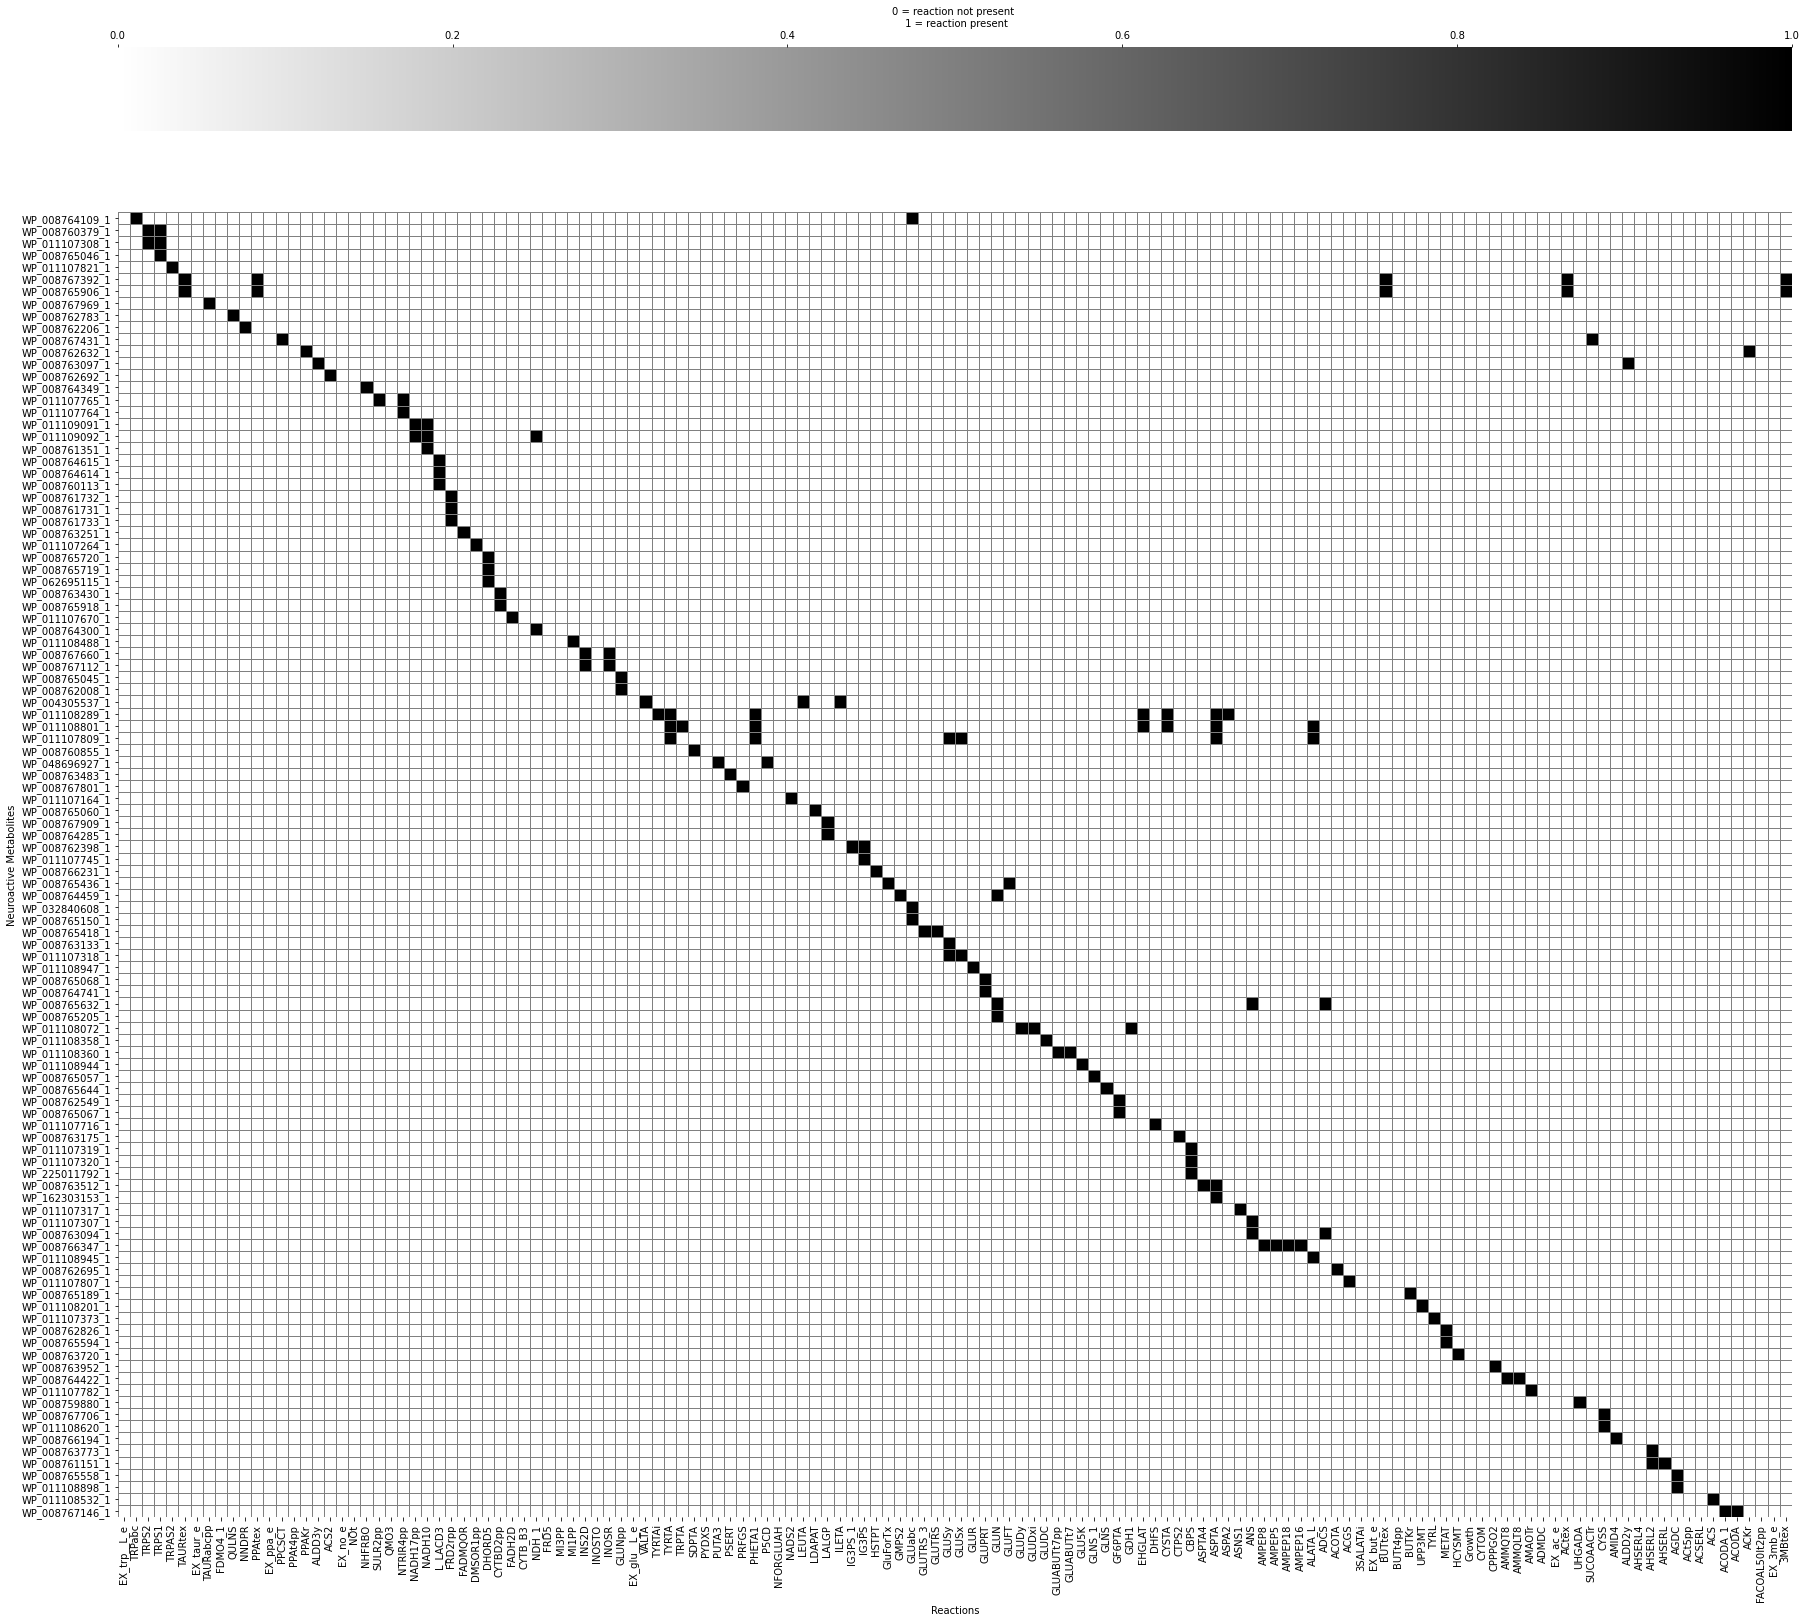

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (30,30))
# plt.figure(figsize = (8,40))

s=sns.heatmap(RxNgenesDF, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = reaction not present \n 1 = reaction present', 'location': 'top'}, linewidth=0.5, linecolor='gray')
s.set(xlabel='Reactions', ylabel='Neuroactive Metabolites')

for l in s.xaxis.get_ticklabels()+s.yaxis.get_ticklabels():
    if 'Transp' in l.get_text():
        l.set_color('m')
    elif 'Ex' in l.get_text():
        l.set_color('b')

# plt.savefig('neuroactiveRxsHeatmap.png',bbox_inches="tight")
# plt.savefig('neuroactiveRxsHeatmap.pdf', format="pdf",bbox_inches="tight")